In [1]:
import glob
import torch
import torch.nn as nn
import numpy as np
from torch.utils.data.dataset import Dataset
import matplotlib.pyplot as plt
from PIL import Image
from tqdm.auto import tqdm
from torchvision.transforms import Compose, ToTensor, Resize, Normalize, RandomHorizontalFlip, ToPILImage
from torch.optim.adam import Adam
from torch.utils.data.dataloader import DataLoader
import torchvision.models as models
import random
import os

## 파라미터 설정

In [2]:

device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [3]:
# 맥 mps 설정
# device = torch.device("mps:0" if torch.backends.mps.is_available() else "cpu")
# print(f"현재 디바이스는 {device} 입니다.")

In [3]:
CFG = {
    'IMG_SIZE':512,
    'EPOCHS':30,
    'LEARNING_RATE':3e-4,
    'BATCH_SIZE':5,
    'SEED':41,
    'train_magnification':20,
    'test_magnification':20,
}

In [4]:
pth_name=f"./git_ignore/pthfile/{CFG['train_magnification']}X_e{CFG['EPOCHS']}.pth"
train_data_path = f"./git_ignore/PDA_mask_img/{CFG['train_magnification']}X/**/*.png"
test_data_path = f"./git_ignore/PDA_mask_img/{CFG['test_magnification']}X/**/*.png"
print(f"pth_name:{pth_name}")
print(f"train_data_path:{train_data_path}")
print(f"test_data_path:{test_data_path}")

pth_name:./git_ignore/pthfile/20X_e30.pth
train_data_path:./git_ignore/PDA_mask_img/20X/**/*.png
test_data_path:./git_ignore/PDA_mask_img/20X/**/*.png


In [5]:
# 시드 고정
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

seed_everything(CFG['SEED']) # Seed 고정

## 데이터 경로지정

In [6]:
train_path_list = sorted(glob.glob(train_data_path))
train_path_list[:10]

['./git_ignore/PDA_mask_img/20X\\C3L-00017-22\\C3L-00017-22 [d=1.01174,x=10073,y=10073,w=518,h=518]-labelled.png',
 './git_ignore/PDA_mask_img/20X\\C3L-00017-22\\C3L-00017-22 [d=1.01174,x=10073,y=10073,w=518,h=518].png',
 './git_ignore/PDA_mask_img/20X\\C3L-00017-22\\C3L-00017-22 [d=1.01174,x=10073,y=10338,w=518,h=518]-labelled.png',
 './git_ignore/PDA_mask_img/20X\\C3L-00017-22\\C3L-00017-22 [d=1.01174,x=10073,y=10338,w=518,h=518].png',
 './git_ignore/PDA_mask_img/20X\\C3L-00017-22\\C3L-00017-22 [d=1.01174,x=10073,y=10603,w=518,h=518]-labelled.png',
 './git_ignore/PDA_mask_img/20X\\C3L-00017-22\\C3L-00017-22 [d=1.01174,x=10073,y=10603,w=518,h=518].png',
 './git_ignore/PDA_mask_img/20X\\C3L-00017-22\\C3L-00017-22 [d=1.01174,x=10073,y=11663,w=518,h=518]-labelled.png',
 './git_ignore/PDA_mask_img/20X\\C3L-00017-22\\C3L-00017-22 [d=1.01174,x=10073,y=11663,w=518,h=518].png',
 './git_ignore/PDA_mask_img/20X\\C3L-00017-22\\C3L-00017-22 [d=1.01174,x=10073,y=11928,w=518,h=518]-labelled.png',
 

In [7]:
test_path_list = sorted(glob.glob(test_data_path))
test_path_list[:10]

['./git_ignore/PDA_mask_img/20X\\C3L-00017-22\\C3L-00017-22 [d=1.01174,x=10073,y=10073,w=518,h=518]-labelled.png',
 './git_ignore/PDA_mask_img/20X\\C3L-00017-22\\C3L-00017-22 [d=1.01174,x=10073,y=10073,w=518,h=518].png',
 './git_ignore/PDA_mask_img/20X\\C3L-00017-22\\C3L-00017-22 [d=1.01174,x=10073,y=10338,w=518,h=518]-labelled.png',
 './git_ignore/PDA_mask_img/20X\\C3L-00017-22\\C3L-00017-22 [d=1.01174,x=10073,y=10338,w=518,h=518].png',
 './git_ignore/PDA_mask_img/20X\\C3L-00017-22\\C3L-00017-22 [d=1.01174,x=10073,y=10603,w=518,h=518]-labelled.png',
 './git_ignore/PDA_mask_img/20X\\C3L-00017-22\\C3L-00017-22 [d=1.01174,x=10073,y=10603,w=518,h=518].png',
 './git_ignore/PDA_mask_img/20X\\C3L-00017-22\\C3L-00017-22 [d=1.01174,x=10073,y=11663,w=518,h=518]-labelled.png',
 './git_ignore/PDA_mask_img/20X\\C3L-00017-22\\C3L-00017-22 [d=1.01174,x=10073,y=11663,w=518,h=518].png',
 './git_ignore/PDA_mask_img/20X\\C3L-00017-22\\C3L-00017-22 [d=1.01174,x=10073,y=11928,w=518,h=518]-labelled.png',
 

In [8]:
# train data path
train_mask_path = train_path_list[0::2]
train_img_path = train_path_list[1::2]
train_mask_path[:10]

['./git_ignore/PDA_mask_img/20X\\C3L-00017-22\\C3L-00017-22 [d=1.01174,x=10073,y=10073,w=518,h=518]-labelled.png',
 './git_ignore/PDA_mask_img/20X\\C3L-00017-22\\C3L-00017-22 [d=1.01174,x=10073,y=10338,w=518,h=518]-labelled.png',
 './git_ignore/PDA_mask_img/20X\\C3L-00017-22\\C3L-00017-22 [d=1.01174,x=10073,y=10603,w=518,h=518]-labelled.png',
 './git_ignore/PDA_mask_img/20X\\C3L-00017-22\\C3L-00017-22 [d=1.01174,x=10073,y=11663,w=518,h=518]-labelled.png',
 './git_ignore/PDA_mask_img/20X\\C3L-00017-22\\C3L-00017-22 [d=1.01174,x=10073,y=11928,w=518,h=518]-labelled.png',
 './git_ignore/PDA_mask_img/20X\\C3L-00017-22\\C3L-00017-22 [d=1.01174,x=10073,y=12193,w=518,h=518]-labelled.png',
 './git_ignore/PDA_mask_img/20X\\C3L-00017-22\\C3L-00017-22 [d=1.01174,x=10073,y=12459,w=518,h=518]-labelled.png',
 './git_ignore/PDA_mask_img/20X\\C3L-00017-22\\C3L-00017-22 [d=1.01174,x=10073,y=12724,w=518,h=518]-labelled.png',
 './git_ignore/PDA_mask_img/20X\\C3L-00017-22\\C3L-00017-22 [d=1.01174,x=10073,y

In [9]:
train_img_path[:10]

['./git_ignore/PDA_mask_img/20X\\C3L-00017-22\\C3L-00017-22 [d=1.01174,x=10073,y=10073,w=518,h=518].png',
 './git_ignore/PDA_mask_img/20X\\C3L-00017-22\\C3L-00017-22 [d=1.01174,x=10073,y=10338,w=518,h=518].png',
 './git_ignore/PDA_mask_img/20X\\C3L-00017-22\\C3L-00017-22 [d=1.01174,x=10073,y=10603,w=518,h=518].png',
 './git_ignore/PDA_mask_img/20X\\C3L-00017-22\\C3L-00017-22 [d=1.01174,x=10073,y=11663,w=518,h=518].png',
 './git_ignore/PDA_mask_img/20X\\C3L-00017-22\\C3L-00017-22 [d=1.01174,x=10073,y=11928,w=518,h=518].png',
 './git_ignore/PDA_mask_img/20X\\C3L-00017-22\\C3L-00017-22 [d=1.01174,x=10073,y=12193,w=518,h=518].png',
 './git_ignore/PDA_mask_img/20X\\C3L-00017-22\\C3L-00017-22 [d=1.01174,x=10073,y=12459,w=518,h=518].png',
 './git_ignore/PDA_mask_img/20X\\C3L-00017-22\\C3L-00017-22 [d=1.01174,x=10073,y=12724,w=518,h=518].png',
 './git_ignore/PDA_mask_img/20X\\C3L-00017-22\\C3L-00017-22 [d=1.01174,x=10073,y=12989,w=518,h=518].png',
 './git_ignore/PDA_mask_img/20X\\C3L-00017-22\

In [10]:
# test data path
test_mask_path = test_path_list[0::2]
test_img_path = test_path_list[1::2]
test_mask_path[:10]

['./git_ignore/PDA_mask_img/20X\\C3L-00017-22\\C3L-00017-22 [d=1.01174,x=10073,y=10073,w=518,h=518]-labelled.png',
 './git_ignore/PDA_mask_img/20X\\C3L-00017-22\\C3L-00017-22 [d=1.01174,x=10073,y=10338,w=518,h=518]-labelled.png',
 './git_ignore/PDA_mask_img/20X\\C3L-00017-22\\C3L-00017-22 [d=1.01174,x=10073,y=10603,w=518,h=518]-labelled.png',
 './git_ignore/PDA_mask_img/20X\\C3L-00017-22\\C3L-00017-22 [d=1.01174,x=10073,y=11663,w=518,h=518]-labelled.png',
 './git_ignore/PDA_mask_img/20X\\C3L-00017-22\\C3L-00017-22 [d=1.01174,x=10073,y=11928,w=518,h=518]-labelled.png',
 './git_ignore/PDA_mask_img/20X\\C3L-00017-22\\C3L-00017-22 [d=1.01174,x=10073,y=12193,w=518,h=518]-labelled.png',
 './git_ignore/PDA_mask_img/20X\\C3L-00017-22\\C3L-00017-22 [d=1.01174,x=10073,y=12459,w=518,h=518]-labelled.png',
 './git_ignore/PDA_mask_img/20X\\C3L-00017-22\\C3L-00017-22 [d=1.01174,x=10073,y=12724,w=518,h=518]-labelled.png',
 './git_ignore/PDA_mask_img/20X\\C3L-00017-22\\C3L-00017-22 [d=1.01174,x=10073,y

In [11]:
test_img_path[:10]

['./git_ignore/PDA_mask_img/20X\\C3L-00017-22\\C3L-00017-22 [d=1.01174,x=10073,y=10073,w=518,h=518].png',
 './git_ignore/PDA_mask_img/20X\\C3L-00017-22\\C3L-00017-22 [d=1.01174,x=10073,y=10338,w=518,h=518].png',
 './git_ignore/PDA_mask_img/20X\\C3L-00017-22\\C3L-00017-22 [d=1.01174,x=10073,y=10603,w=518,h=518].png',
 './git_ignore/PDA_mask_img/20X\\C3L-00017-22\\C3L-00017-22 [d=1.01174,x=10073,y=11663,w=518,h=518].png',
 './git_ignore/PDA_mask_img/20X\\C3L-00017-22\\C3L-00017-22 [d=1.01174,x=10073,y=11928,w=518,h=518].png',
 './git_ignore/PDA_mask_img/20X\\C3L-00017-22\\C3L-00017-22 [d=1.01174,x=10073,y=12193,w=518,h=518].png',
 './git_ignore/PDA_mask_img/20X\\C3L-00017-22\\C3L-00017-22 [d=1.01174,x=10073,y=12459,w=518,h=518].png',
 './git_ignore/PDA_mask_img/20X\\C3L-00017-22\\C3L-00017-22 [d=1.01174,x=10073,y=12724,w=518,h=518].png',
 './git_ignore/PDA_mask_img/20X\\C3L-00017-22\\C3L-00017-22 [d=1.01174,x=10073,y=12989,w=518,h=518].png',
 './git_ignore/PDA_mask_img/20X\\C3L-00017-22\

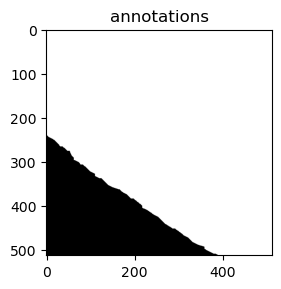

In [12]:
annotation = Image.open(train_mask_path[0])
plt.subplot(1,2,1)
plt.title("annotations")
plt.imshow(annotation)

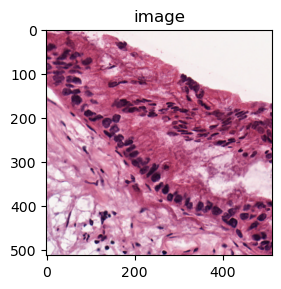

In [13]:
image = Image.open(train_img_path[0])
plt.subplot(1,2,2)
plt.title("image")
plt.imshow(image)


In [14]:
# Custom Dataset
class CustomDataset(Dataset):
    def __init__(self, img_path, mask_path, train = True, img_transform = None, mask_transform = None):
        self.images = img_path
        self.annotations = mask_path
        
        # 학습용 or 평가용
        self.X_train = self.images[:int(0.8 * len(self.images))]
        self.X_test = self.images[int(0.8 * len(self.images)):]

        self.Y_train = self.annotations[:int(0.8 * len(self.annotations))]
        self.Y_test = self.annotations[int(0.8 * len(self.annotations)):]

        self.train = train
        self.img_transform = img_transform
        self.mask_transform = mask_transform


    def __len__(self):
        if self.train:
            return len(self.X_train) # 학습용 데이터셋 길이
        else:
            return len(self.X_test) # 평가용 데이터셋 길이
        
    
    def __getitem__(self, i):
        if self.train:  # 학습용 데이터
            X_train = Image.open(self.X_train[i])
            X_train = self.img_transform(X_train)
            Y_train = Image.open(self.Y_train[i])
            Y_train = self.mask_transform(Y_train)

            return X_train, Y_train
        
        else:  # 평가용 데이터
            X_test = Image.open(self.X_test[i])
            X_test = self.img_transform(X_test)
            Y_test = Image.open(self.Y_test[i])
            Y_test = self.mask_transform(Y_test)

            return X_test, Y_test

In [32]:
# U-Net 모델 정의
class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()
        # Transfer the ResNet model for encoding
        self.resnet = models.resnet50(pretrained=True)
        
        self.encoder1 = nn.Sequential(self.resnet.conv1, self.resnet.bn1, self.resnet.relu, self.resnet.maxpool) #64
        self.encoder2 = self.resnet.layer1  # 256
        self.encoder3 = self.resnet.layer2  # 512
        self.encoder4 = self.resnet.layer3  # 1024
        self.encoder5 = self.resnet.layer4  # 2048
        
        self.upsample4 = nn.ConvTranspose2d(2048, 1024, kernel_size=2, stride = 2)
        self.dec4_1 = nn.Conv2d(2048, 1024, kernel_size=3, padding = 1)
        self.dec4_2 = nn.Conv2d(1024, 512, kernel_size=3, padding = 1)

        self.upsample3 = nn.ConvTranspose2d(512, 512, kernel_size=2, stride = 2)
        self.dec3_1 = nn.Conv2d(1024, 512, kernel_size = 3, padding = 1)
        self.dec3_2 = nn.Conv2d(512, 256, kernel_size=3, padding=1)

        self.upsample2 = nn.ConvTranspose2d(256, 256, kernel_size=2, stride = 2)
        self.dec2_1 = nn.Conv2d(512, 256, kernel_size = 3, padding = 1)
        self.dec2_2 = nn.Conv2d(256, 128, kernel_size=3, padding=1)

        self.upsample1 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride = 2)
        self.dec1_1 = nn.Conv2d(128, 64, kernel_size = 3, padding = 1)
        self.dec1_2 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.dec1_3 = nn.Conv2d(64, 1, kernel_size=1)

        # 합성곱과 업샘플링층의 활성화 함수
        self.relu = nn.ReLU()

    def forward(self, x):
        # Encoding
        x1 = self.encoder1(x)
        x2 = self.encoder2(x1)
        x3 = self.encoder3(x2)
        x4 = self.encoder4(x3)
        x5 = self.encoder5(x4)
        
        # Decoding
        x = self.upsample4(x5)
        x = torch.cat([x, x4], dim=1)
        x = self.dec4_1(x)
        x = self.relu(x)
        x = self.dec4_2(x)
        x = self.relu(x)

        x = self.upsample3(x)
        x = torch.cat([x, x3], dim=1)
        x = self.dec3_1(x)
        x = self.relu(x)
        x = self.dec3_2(x)
        x = self.relu(x)

        x = self.upsample2(x)
        x = torch.cat([x, x2], dim=1)
        x = self.dec2_1(x)
        x = self.relu(x)
        x = self.dec2_2(x)
        x = self.relu(x)

        x = self.upsample1(x)
        x = torch.cat([x, x1], dim=1)
        x = self.dec1_1(x)
        x = self.relu(x)
        x = self.dec1_2(x)
        x = self.relu(x)
        x = self.dec1_3(x)

        x = torch.squeeze(x)
        
        return x

## 데이터 불러오기

In [33]:
mask_transform = Compose([Resize((CFG['IMG_SIZE'],CFG['IMG_SIZE'])),
                    ToTensor()])

# 학습용 데이터
train_set = CustomDataset(img_path = train_img_path,
                 mask_path = train_mask_path,
                 mask_transform = mask_transform,
                 img_transform = mask_transform)


In [34]:
imgs = [item[0] for item in train_set]
imgs = torch.stack(imgs, dim=0).numpy()

# 데이터 정규화를 위한 평균값
mean_r = imgs[:,0,:,:].mean()
mean_g = imgs[:,1,:,:].mean()
mean_b = imgs[:,2,:,:].mean()
print(mean_r, mean_g, mean_b)

# 데이터 정규화를 위한 표준편차
std_r = imgs[:,0,:,:].std()
std_g = imgs[:,1,:,:].std()
std_b = imgs[:,2,:,:].std()
print(std_r, std_g, std_b)

img_transform = Compose([Resize((CFG['IMG_SIZE'],CFG['IMG_SIZE'])),
                      ToTensor(),
                      Normalize(mean=(mean_r,mean_g,mean_b), std = (std_r,std_g,std_b)),
                      RandomHorizontalFlip()])

0.79447055 0.63140094 0.738801
0.1624873 0.2171353 0.15946886


In [35]:
# 학습용 데이터
train_set = CustomDataset(img_path = train_img_path,
                          mask_path = train_mask_path,
                          mask_transform = mask_transform,
                          img_transform=img_transform)
# 평가용 데이터
test_set = CustomDataset(img_path = test_img_path,
                         mask_path=test_mask_path,
                         mask_transform = mask_transform,
                         img_transform=mask_transform,
                         train=False)

In [36]:
train_loader = DataLoader(train_set, batch_size = CFG["BATCH_SIZE"], shuffle = True)
test_loader = DataLoader(test_set)

In [37]:
print(len(train_set),len(test_set))

3514 879


In [38]:
print(len(train_loader),len(test_loader))

703 879


## 학습

In [39]:
model = UNet().to(device)

optimizer = Adam(params = model.parameters(), lr = CFG["LEARNING_RATE"])
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=2, threshold_mode='abs', min_lr=1e-8, verbose=True)

In [40]:
for epoch in range(CFG["EPOCHS"]):

    for data, label in tqdm(train_loader):
        optimizer.zero_grad()
        preds = model(data.to(device))
        
        label = torch.squeeze(label)
        loss = nn.BCEWithLogitsLoss()(preds, label.type(torch.FloatTensor).to(device))
        loss.backward()
        optimizer.step()
    print(f"epoch{epoch+1} loss:{loss.item()}")

torch.save(model.state_dict(), pth_name)

  0%|          | 0/703 [00:00<?, ?it/s]

RuntimeError: Sizes of tensors must match except in dimension 1. Expected size 256 but got size 128 for tensor number 1 in the list.

## 결과 저장

In [23]:
# output_path 설정
epochs = CFG["EPOCHS"]
output_name = f"{train_magnification}_{test_magnification}_{epochs}"
output_path = f"git_ignore/output/output({output_name})"
output_path

'git_ignore/output(20X_20X_30)'

KeyboardInterrupt: 

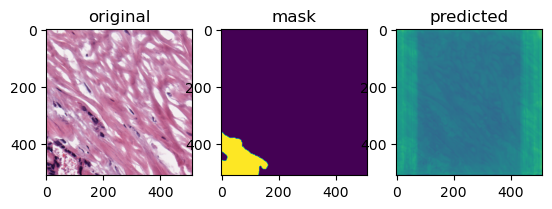

In [24]:
# output_save
os.mkdir(output_path)
for i in range(len(test_loader)):
    model.load_state_dict(torch.load(CFG["pth_name"], map_location=device))
    data, label = test_set[i]
    pred = model(torch.unsqueeze(data, dim=0).to(device))
    pred = pred.to("cpu")
    label = torch.squeeze(label)
    with torch.no_grad():
        plt.subplot(1,3,1)
        plt.title("original")
        plt.imshow(ToPILImage()(data))
        plt.subplot(1,3,2)
        plt.title("mask")
        plt.imshow(label)
        plt.subplot(1,3,3)
        plt.title("predicted")
        plt.imshow(pred)
        plt.savefig(f'{output_path}/{output_name}_{i+1}.png')